In [ ]:
colab = False
if colab:
    !pip install datasets langdetect
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl")

In [ ]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

import sys
import os
import torch
from torch.utils.data import DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline, TrainerCallback, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output

if colab:
  from scbn_rqtl import text_classification_functions as tcf
  from scbn_rqtl import labeling_widget
else:
  import text_classification_functions as tcf
  import labeling_widget

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
if colab:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    hf_token_write = userdata.get('HF_TOKEN_WRITE')
else:
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

try:
    if hf_token is None:
        raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
    if hf_token_write is None:
        raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")

    masked_hf_token = mask_token(hf_token)
    masked_hf_token_write = mask_token(hf_token_write)

    print(f"Using HuggingFace token: {masked_hf_token}")
    print(f"Using HuggingFace write token: {masked_hf_token_write}")
except ValueError as e:
    print(e)

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
Transformers version: 4.46.2
CUDA device: Tesla T4
Using HuggingFace token: hf_B*****************************PHte
Using HuggingFace write token: hf_E*****************************hyNP


In [ ]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# TL model

### Testing current model

Loading Test split from dataset:

In [28]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/239 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/121 [00:00<?, ? examples/s]

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
118,How many terms can the president hold office i...,0
119,write a performance review for a new data scie...,0
120,I like to play sharp lines in chess. What woul...,0


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Classifying: 100%|██████████| 121/121 [00:13<00:00,  8.97it/s]


Accuracy: 0.8430
F1 Score: 0.8485
Cross Entropy Loss: 0.5998


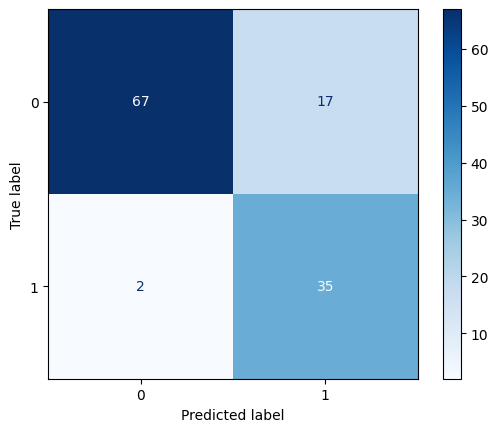

In [29]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [30]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df, target_column = 'text', feature_suffix = 'tl')
display(tl_classification_df.sample(5))

Classifying: 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


,text,label,pred_label_tl,prob_tl
99,Write an article about the Instruction of Tiza...,0,learn,0.997847
13,yes can you please separate male patients and ...,0,test,0.990968
44,triathlete actresses,0,learn,0.997484
34,# python implementation of fibonacci numbers\n,0,learn,0.997552
45,what about the Baywaych Hawaii girls,0,learn,0.996788


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory.

Load train dataset:

In [31]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 239
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
234,"fix this ""it was well paid, but not that well ...",0
235,"fix this ""Yeah, I took the job due to a referr...",0
236,"Hi, I work as a data analyst for telecom compa...",0
237,start explaining probability theory,0
238,Is it possible to write a powershell script wh...,0


### Training with Tensorflow backend

Epoch 1/6
21/21 [==============================] - 34s 665ms/step - loss: 0.6829 - accuracy: 0.5808 - val_loss: 0.6541 - val_accuracy: 0.7639
Epoch 2/6
21/21 [==============================] - 10s 495ms/step - loss: 0.6315 - accuracy: 0.7784 - val_loss: 0.5824 - val_accuracy: 0.8472
Epoch 3/6
21/21 [==============================] - 12s 559ms/step - loss: 0.4975 - accuracy: 0.9222 - val_loss: 0.4382 - val_accuracy: 0.8889
Epoch 4/6
21/21 [==============================] - 12s 558ms/step - loss: 0.3094 - accuracy: 0.9521 - val_loss: 0.3303 - val_accuracy: 0.9028
Epoch 5/6
21/21 [==============================] - 11s 503ms/step - loss: 0.1684 - accuracy: 0.9820 - val_loss: 0.2741 - val_accuracy: 0.9028
Epoch 6/6
21/21 [==============================] - 11s 508ms/step - loss: 0.0794 - accuracy: 1.0000 - val_loss: 0.2381 - val_accuracy: 0.9444


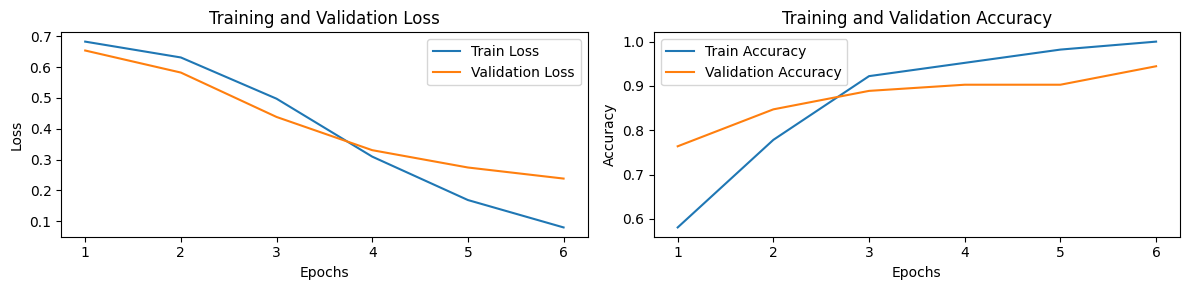

In [32]:
# Main parameters:
learning_rate=0.00001
n_epochs=6

# Split data into train and test sets using `datasets` library
dataset_split = dataset.train_test_split(test_size=0.3, seed=21)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [33]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing/tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing/special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing/vocab.txt',
 'fine-tuned-distilbert-tl-testing/added_tokens.json',
 'fine-tuned-distilbert-tl-testing/tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (the training easily overfits). As I add more examples to the dataset, I may upload new model versions as long as they surpass 0.85 accuracy and get below 0.4 cross entropy loss on test data (0.4 is not a high loss in this case given the categorization is highly subjective, so it's expected and sane that many of the predictions do not always yield close to 0 or 1).

Some layers from the model checkpoint at fine-tuned-distilbert-tl-testing were not used when initializing TFDistilBertForSequenceClassification: ['dropout_179']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl-testing and are newly initialized: ['dropout_199']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fallback to HuggingFace pipeline.


Classifying: 100%|██████████| 121/121 [00:19<00:00,  6.29it/s]


Accuracy: 0.8347
F1 Score: 0.8369
Cross Entropy Loss: 0.4042


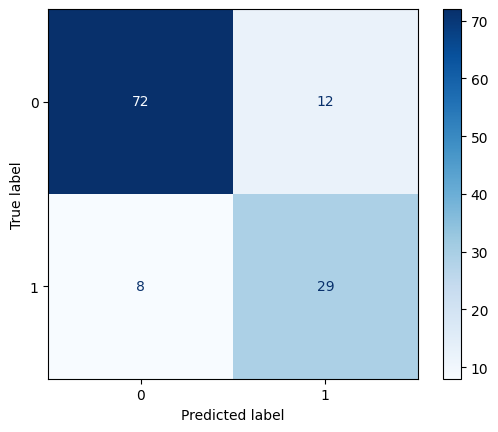

In [34]:
# tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.TensorflowClassifier(model_path="fine-tuned-distilbert-tl-testing", label_map=tl_label_map, verbose = True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [35]:
streaming = True

lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token,
  streaming=streaming
)
print(lmsys_dataset)

if not streaming:
  print('Data is cached at:\n')
  for file_info in lmsys_dataset['train'].cache_files:
      filename = file_info['filename']
      file_size = os.path.getsize(filename)
      i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
      print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

IterableDatasetDict({
    train: IterableDataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_shards: 6
    })
})


In [36]:
if not streaming:
  n_samples = 500
  df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
  print(f"Retrieved {n_samples} samples")
  display(df_sample.head(2))
  print('...')
  display(df_sample.tail(2))

if streaming:
  # Take a sample from the streamed dataset
  n_samples = 500
  streamed_samples = []
  for i, row in enumerate(lmsys_dataset['train']):
      streamed_samples.append(row)
      if i + 1 == n_samples:  # Collect only the desired number of samples
          break

  # Convert the collected samples to a Pandas DataFrame
  df_sample = pd.DataFrame(streamed_samples)
  print(f"Retrieved {n_samples} samples")
  display(df_sample.head(2))
  print('...')
  display(df_sample.tail(2))

Retrieved 500 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
0,33f01939a744455c869cb234afca47f1,wizardlm-13b,[{'content': 'how can identity protection serv...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
1,1e230e55efea4edab95db9cb87f6a9cb,vicuna-13b,[{'content': 'Beside OFAC's selective sanction...,6,English,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
498,1175f7c3c0f0495597f4ba639b7db7d9,vicuna-13b,[{'content': 'You are the text completion mode...,1,English,"[{'categories': {'harassment': False, 'harassm...",False
499,b8d2791cb14e41fcba6b1e5a22ecc2f7,koala-13b,"[{'content': 'At beginning, I have 9 apples,a...",1,English,"[{'categories': {'harassment': False, 'harassm...",False


In [37]:
filter_language = 'English'
max_char_length = 300 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']}
                 for entry in row['conversation']
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,how can identity protection services help prot...,English
1,Beside OFAC's selective sanction that target t...,English
2,are there other types of US sanctions that you...,English
3,please make organized conclusion in bullet lis...,English
4,"can you please revise the answer above again, ...",English
...,...,...
569,Can you give me the best resource,English
570,Can we make a neuron in lisp ?,English
571,Give me an introduction over 200 words for Mia...,English
572,Give me a list of digital products for kids th...,English


Classify random prompts:

In [38]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

test (0.948)
you are not good

learn (0.781)
she started live stream to show how she is doing tube method with wearing knee high socks coordinate. viewers are
fascinated because she is so cute. describe the detail of the stream

learn (0.966)
write a laravel controller that store file

test (0.778)
viet chuong trinh python đem no luong ky tu nhap vao ban phim

learn (0.968)
give me an introduction over 200 words for huai an real chemical industry co., ltd, a chemical company in yuanji
industry zone, huaiyin, huaian, china



### Manual labeling

See dataset-handling.ipynb

In [26]:
tl_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
tl_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

Push new labeled texts to dataset:

In [27]:
tl_labeling_widget.update_dataset(
    dataset_name="reddgr/tl-test-learn-prompts",
    split_name="test", # We will add examples to the test split this time
    hf_token=hf_token_write
)

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.10k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/239 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/108 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Successfully pushed 13 records to reddgr/tl-test-learn-prompts test split.


### Push model to hub

In [39]:
model.push_to_hub("reddgr/tl-test-learn-prompt-classifier", token=hf_token_write)
tokenizer.push_to_hub("reddgr/tl-test-learn-prompt-classifier", token=hf_token_write)

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reddgr/tl-test-learn-prompt-classifier/commit/2bbfc01fc025ef16971c09398925f710f1a94a24', commit_message='Upload tokenizer', commit_description='', oid='2bbfc01fc025ef16971c09398925f710f1a94a24', pr_url=None, repo_url=RepoUrl('https://huggingface.co/reddgr/tl-test-learn-prompt-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='reddgr/tl-test-learn-prompt-classifier'), pr_revision=None, pr_num=None)